Numerator: [8, 0, 6, 0, 1]
Denominator:  [0, 3, 0, 1]


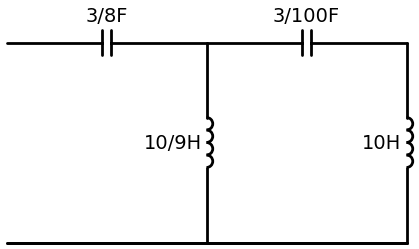

In [ ]:
# UNCOMMENT THE BELOW TWO LINES WHEN USING GOOGLE COLAB
# !pip install schemdraw
# !pip install sympy

import schemdraw
import math
from schemdraw import Drawing, elements as elm
from sympy import apart, symbols, expand, simplify, Poly, roots, factor

# Define the symbol
s = symbols('s')

# for scaling the circuit diagram
scale = 0.4
reason_of_invalid = ["No Error"]

# Checks if the input is Practically realisable or not
def is_valid_input(exp):
    exp = simplify(exp)

    num, den = exp.as_numer_denom()
    num = Poly(num, s)
    den = Poly(den, s)

    num_deg = 0;
    if (num.has(s)): num_deg = num.degree(s)
    den_deg = 0;
    if (den.has(s)): den_deg = den.degree(s)

    if(abs(num_deg - den_deg) > 1):
      reason_of_invalid.append("Difference in the degrees of numerator and denominator is more than Unity")
      return False


    num_dict = roots(num, s)
    den_dict = roots(den, s)

    # print("Numerator roots:", num_dict)
    # print("Denominator roots:", den_dict)

    isvalid = True
    num_has_imaginary = False
    den_has_imaginary = False

    for key, value in num_dict.items():
        real_part, imag_part = key.as_real_imag()

        if real_part > 0 or value > 1:
            reason_of_invalid.append("Repeated Roots or Roots with Positive Real Part in Numerator")
            return False
        if imag_part != 0:
            num_has_imaginary = True

    for key, value in den_dict.items():
        real_part, imag_part = key.as_real_imag()

        if real_part > 0 or value > 1:
            reason_of_invalid.append("Repeated Roots or Roots with Positive Real Part in Denominator")
            return False
        if imag_part != 0:
            den_has_imaginary = True

    if ((not num_has_imaginary) and (not den_has_imaginary)) and len(num_dict) == len(den_dict):
        num_list = [abs(root) for root in num_dict.keys()]
        den_list = [abs(root) for root in den_dict.keys()]

        num_list.sort()
        den_list.sort()

        if num_list[0] > den_list[0]:
            num_list, den_list = den_list, num_list

        store = []
        for n_root, d_root in zip(num_list, den_list):
            store.extend([n_root, d_root])

        for i in range(1, len(store)):
            if store[i - 1] > store[i]:
                reason_of_invalid.append("The Poles and Zeroes are not in alternate fashion on Real axis")
                return False

    return True


#-------------------CAUER FUNCTIONS START------------------------------

# Takes input of the expression string from inside the
# function and converts it into num and den arrays for the continuous division
def get_num_den(exp, num, den):
    numerator, denominator = exp.as_numer_denom()
    numerator = expand(numerator)
    denominator = expand(denominator)

    if numerator.has(s):
        for i in range(numerator.as_poly().degree() + 1):
            num.append(numerator.as_poly().coeff_monomial(s**i))
    else:
        num.append(numerator)

    if denominator.has(s):
        for i in range(denominator.as_poly().degree() + 1):
            den.append(denominator.as_poly().coeff_monomial(s**i))
    else:
        den.append(denominator)

def cauer1(num, den, ans):

    n = len(num)
    m = len(den)
    if(m == 0 or n == 0): return

    shift = n-m
    quotient = num[n - 1] / den[m - 1]

    for i in range(m):
        num[i + shift] -= (den[i] * quotient)

    while len(num) > 0 and math.fabs(num[-1]) < 1e-6:
        num.pop()

    ans.append([quotient, shift])
    cauer1(den, num, ans)

def cauer2(num, den, ans):

    n = len(num)
    m = len(den)
    if(m == 0 or n == 0): return

    # get the lowest nonzero coefficient in numerator
    i = 0
    while (i < n and num[i] == 0): i += 1

    # get the lowest nonzero coefficient in denominator
    j = 0
    while (j < m and den[j] == 0): j += 1

    if(i >= n or j >= m): return

    # number of elements to be removed in
    # current iteration from the start of the array
    removal = min(i, j)

    shift = i - j
    quotient = 0
    if(math.fabs(den[j]) > 1e-6): quotient = num[i] / den[j]

    while (i < n and j < m) :
        num[i] -= quotient*den[j]
        i += 1
        j += 1

    num.reverse()
    den.reverse()
    for i in range(removal):
      num.pop()
      den.pop()

    num.reverse()
    den.reverse()

    ans.append([quotient, shift])
    cauer2(den, num, ans)

def draw_z_circuit(ans):

    def add_ele_x(x, ele):
        if(ele[1] == 0):
            x += elm.Resistor().right(10*scale).label(f"{ele[0]}Ω")
        elif(ele[1] == 1):
            x += elm.Inductor().right(10*scale).label(f"{ele[0]}H")
        else:
            x += elm.Capacitor().right(10*scale).label(f"{1/ele[0]}F")

    def add_ele_y(x, ele):
        if ele[0] == 0:
            x += elm.Line().down(10*scale)
            return
        if(ele[1] == 0):
            x += elm.Resistor().down(10*scale).label(f"{1/ele[0]}Ω")
        elif(ele[1] == -1):
            x += elm.Inductor().down(10*scale).label(f"{1/ele[0]}H")
        else:
            x += elm.Capacitor().down(10*scale).label(f"{ele[0]}F")

    if(len(ans) % 2 == 1): ans.append([0, 0])
    with schemdraw.Drawing() as x:
        for i in range(0, len(ans), 2):
            add_ele_x(x, ans[i])
            x.push()
            add_ele_y(x, ans[i+1])
            x += elm.Line().left(10*scale)
            x += elm.Line().right(10*scale)
            x.pop()
    return

def draw_y_circuit(ans):

    def add_ele_x(x, ele):
        if(ele[1] == 0):
            x += elm.Resistor().right(10*scale).label(f"{ele[0]}Ω")
        elif(ele[1] == 1):
            x += elm.Inductor().right(10*scale).label(f"{ele[0]}H")
        else:
            x += elm.Capacitor().right(10*scale).label(f"{1/ele[0]}F")

    def add_ele_y(x, ele):
        if ele[0] == 0:
            x += elm.Line().down(10*scale)
            return
        if(ele[1] == 0):
            x += elm.Resistor().down(10*scale).label(f"{1/ele[0]}Ω")
        elif(ele[1] == -1):
            x += elm.Inductor().down(10*scale).label(f"{1/ele[0]}H")
        else:
            x += elm.Capacitor().down(10*scale).label(f"{ele[0]}F")

    if(len(ans) % 2 == 0): ans.append([0, 0])
    with schemdraw.Drawing() as y:

        y += elm.Line().right(10*scale)
        y.push()
        add_ele_y(y, ans[0])
        y += elm.Line().left(10*scale)
        y.pop()

        for i in range(1, len(ans), 2):
            add_ele_x(y, ans[i])
            y.push()
            add_ele_y(y, ans[i+1])
            y += elm.Line().left(10*scale)
            y += elm.Line().right(10*scale)
            y.pop()
    return

def cauer_handler():
    cauer_form = input("Enter Cauer Form (1 or 2): ")
    exp_type = input("Enter 1 for Z(s) or 2 for Y(s): ")

    cauer_form = int(cauer_form)
    exp_type = int(exp_type)

    num = []
    den = []
    ans = []

    exp = input("Enter the Expression (use lowercase s): ")
    exp = simplify(exp)
    get_num_den(exp, num, den)

    print("Numerator:", num)
    print("Denominator: ", den)

    # get the expression into Z format
    if(exp_type == 2): num, den = den, num
    n = len(num)
    m = len(den)

    if(is_valid_input(exp) == False):
        print("INVALID INPUT: The given function cannot be realised Practically")
        print(reason_of_invalid[-1])

    else:
        if (cauer_form == 1):
            if(n > m):
                cauer1(num, den, ans)
                draw_z_circuit(ans)
            elif (n < m):
                cauer1(den, num, ans)
                draw_y_circuit(ans)
            else:
                i = n-1
                while (num[i] == den[i]): i -= 1

                if (num[i] < den[i]):
                    cauer1(den, num, ans)
                    draw_y_circuit(ans)
                else:
                    cauer1(num, den, ans)
                    draw_z_circuit(ans)
        else:
            while(len(num) < len(den)): num.append(0)
            while(len(den) < len(num)): den.append(0)

            i = 0;
            while(num[i] == den[i]): i += 1

            if(num[i] > den[i]):
                cauer2(num, den, ans)
                draw_z_circuit(ans)
            else:
                cauer2(den, num, ans)
                draw_y_circuit(ans)
    return

#-------------------CAUER FUNCTIONS END------------------------------


#-------------------FOSTER FUNCTIONS START------------------------------

# returns the array of coeffs {A, B, C, D, E} in ( As + B )/( Cs^2 + Ds + E ) for each partial fraction term
def get_partial_frac(exp, flag, pf_array):

    numerator, denominator = exp.as_numer_denom()
    numerator = numerator.as_poly()
    denominator = denominator.as_poly()
    if flag:
      exp = apart(exp*(1/s))
    else:
      exp = apart(exp)

    terms = exp.as_ordered_terms()

    coeffs = []

    # Loop through each term to access coefficients
    for i, term in enumerate(terms, 1):

        if flag:
          term = apart(term*s)

        # print(f"\nTerm {i}: {term}")

        num, den = term.as_numer_denom()
        num_poly = num.as_poly()
        den_poly = den.as_poly()

        curr_coeff = []
        if num.has(s):
          curr_coeff.append(num_poly.coeff_monomial(s))
          curr_coeff.append(num_poly.coeff_monomial(1))
        else:
          curr_coeff.append(0)
          curr_coeff.append(num)

        if den.has(s):
          curr_coeff.append(den_poly.coeff_monomial(s**2))
          curr_coeff.append(den_poly.coeff_monomial(s))
          curr_coeff.append(den_poly.coeff_monomial(1))
        else:
          curr_coeff.append(0)
          curr_coeff.append(0)
          curr_coeff.append(den)


        div_num = (curr_coeff[2] if curr_coeff[2] > 0 else
                    curr_coeff[3] if curr_coeff[3] > 0 else
                    curr_coeff[4])

        for i in range(5): curr_coeff[i] /= div_num

        coeffs.append(curr_coeff)
        pf_array.append(term)
    #     print("  Extracted value curr_coeff:", curr_coeff)
    # print("\nFinal Partial Fraction Expression:", exp)
    return coeffs

def draw_foster1(coeffs):
    with schemdraw.Drawing() as d1:
        d1 += elm.Line().up(10*scale)
        for i, element in enumerate(coeffs):

            d1 += elm.Line().right(2*scale)

            if (element[0] != 0 and (element[2] + element[3]) > 0):
                d1.push()
                d1 += elm.Line().up(2*scale)
                if(element[3]!=0):
                  d1 += elm.Inductor().right(10*scale).label(f"{element[0]/element[4]}H")
                else:
                  d1 += elm.Inductor().right(10*scale).label(f"{element[0]/element[4]}H")
                d1 += elm.Line().down(2*scale)
                d1.pop()
                d1 += elm.Line().down(2*scale)
                if(element[3]!=0):
                  d1 += elm.Resistor().right(10*scale).label(f"{element[0]}Ω")
                else:
                  d1 += elm.Capacitor().right(10*scale).label(f"{1/element[0]}F")
                d1 += elm.Line().up(2*scale)

            elif element[0] != 0:
                d1 += elm.Inductor().right(10*scale).label(f"{element[0]}H")

            elif element[4] == 0:
                d1 += elm.Capacitor().right(10*scale).label(f"{1/element[1]}F")

            elif element[0] == 0 and element[2] == 0 and element[3] == 0:
                d1 += elm.Resistor().right(10*scale).label(f"{element[1]}Ω")

            else:
                d1.push()
                d1 += elm.Line().up(2*scale)
                d1 += elm.Capacitor().right(10*scale).label(f"{1/element[1]}F")
                d1 += elm.Line().down(2*scale)
                d1.pop()
                d1 += elm.Line().down(2*scale)
                d1 += elm.Resistor().right(10*scale).label(f"{element[1]/element[4]}Ω")
                d1 += elm.Line().up(2*scale)

            d1 += elm.Line().right(2*scale)

        d1 += elm.Line().down(10*scale)
        # final drawing
        d1.draw()

def draw_foster2(coeffs):
    with schemdraw.Drawing() as d1:
        for i, element in enumerate(coeffs):

            d1.push()
            d1 += elm.Line().right(10*scale)

            if (element[0] + element[2] + element[3] == 0):
                d1.push()
                d1 += elm.Line().right(10*scale)
                d1 += elm.Line().down(5*scale)
                d1 += elm.Resistor().down(10*scale).label(f"{element[1]}Ω")
                d1 += elm.Line().down(5*scale)

            elif (element[0] != 0 and (element[2] + element[3]) == 0):
                d1.push()
                d1 += elm.Line().right(10*scale)
                d1 += elm.Line().down(5*scale)
                d1 += elm.Capacitor().down(10*scale).label(f"{element[0]}F")
                d1 += elm.Line().down(5*scale)

            elif (element[0] == 0 and element[2] == 0 and element[4] == 0):
                d1.push()
                d1 += elm.Line().right(10*scale)
                d1 += elm.Line().down(5*scale)
                d1 += elm.Inductor().down(10*scale).label(f"{1/element[1]}H")
                d1 += elm.Line().down(5*scale)

            elif (element[0] == 0 and element[2] == 0):
                d1.push()
                d1 += elm.Line().right(10*scale)
                d1 += elm.Inductor().down(10*scale).label(f"{1/element[1]}H")
                d1 += elm.Resistor().down(10*scale).label(f"{element[4]/element[1]}Ω")
            elif (element[1] == 0 and element[2] == 0):
                d1.push()
                d1 += elm.Line().right(10*scale)
                d1 += elm.Capacitor().down(10*scale).label(f"{element[0]/element[4]}F")
                d1 += elm.Resistor().down(10*scale).label(f"{1/element[0]}Ω")

            elif (element[1] == 0 and element[3] == 0):
                d1.push()
                d1 += elm.Line().right(10*scale)
                d1 += elm.Inductor().down(10*scale).label(f"{1/element[0]}H")
                d1 += elm.Capacitor().down(10*scale).label(f"{element[0]/element[4]}F")


            d1 += elm.Line().left(20*scale)
            d1.pop()
        # final drawing
        d1.draw()

def foster_handler():
    foster_type = input("Enter the type of Foster Form(1 or 2): ")
    exp_type = input("Enter 1 for Z(s) or 2 for Y(s): ")

    foster_type = int(foster_type)
    exp_type = int(exp_type)

    exp = input("Enter the Expression (use lowercase s): ")
    exp = simplify(exp)

    if(is_valid_input(exp) == False):
        print("\nINVALID INPUT: The given function cannot be realised Practically ")
        print(reason_of_invalid[-1])

    else:
        terms = []
        if(foster_type + exp_type == 3):
            num, den = exp.as_numer_denom()
            exp = Poly(den)/Poly(num)

        coeffs = get_partial_frac(exp, False, terms)
        flag = False
        for ele in coeffs:
            for i in range(5):
                if ele[i] < 0:
                    flag = True
                    break

        if flag:
            terms = []
            coeffs = get_partial_frac(exp, True, terms)

        for i in range(len(coeffs)):
            print("term ", i+1, ": ", simplify(terms[i]), "\n")
            print(coeffs[i], "\n\n")

        if(foster_type == 1): draw_foster1(coeffs)
        else: draw_foster2(coeffs)
    return

#--------------------------FOSTER FUNCTIONS END---------------------------


def main():
    FOSTER = 1
    CAUER = 2
    design_type = input("Enter 1 for Foster or 2 for Cauer: ")
    design_type = int(design_type)

    foster_handler() if (design_type == FOSTER) else cauer_handler()
    return


if __name__ == "__main__":
    main()

